# Pairs Trading Strategy: Stocks L and O

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 5)

## 1. Load Data

In [106]:
df = pd.read_csv('simulated_prices.csv')
stock_L = df['L'].values
stock_O = df['O'].values
dates = df['Date'].values

print(f"Data: {len(df)} trading days, {df['Date'].iloc[0]} to {df['Date'].iloc[-1]}")

Data: 2521 trading days, Y0-M01-D02 to Y9-M08-D30


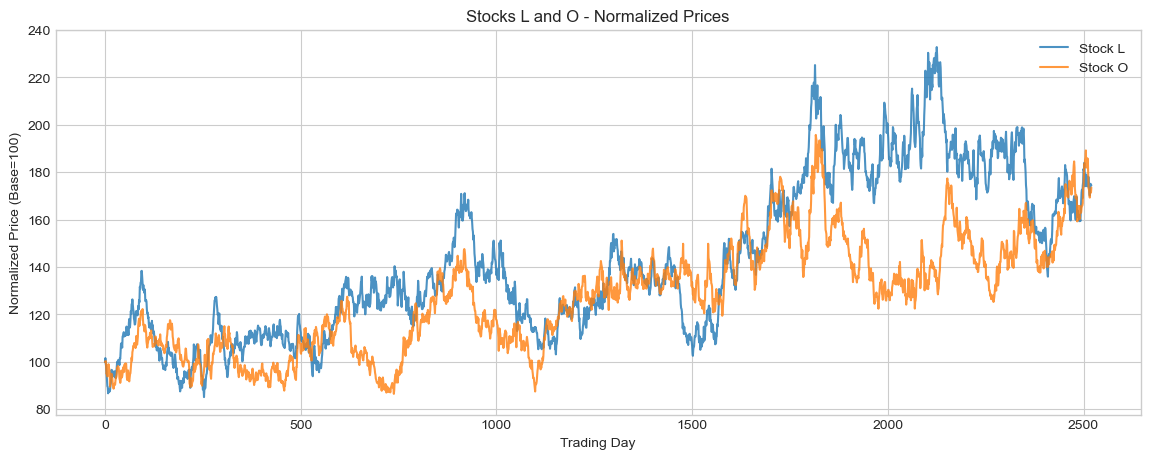

In [107]:
# Plot normalized prices
plt.plot(stock_L / stock_L[0] * 100, label='Stock L', alpha=0.8)
plt.plot(stock_O / stock_O[0] * 100, label='Stock O', alpha=0.8)
plt.xlabel('Trading Day')
plt.ylabel('Normalized Price (Base=100)')
plt.title('Stocks L and O - Normalized Prices')
plt.legend()
plt.show()

## 2. Cointegration Test

In [108]:
coint_stat, pvalue, _ = coint(stock_L, stock_O)
print(f"Engle-Granger Cointegration Test:")
print(f"  Test Statistic: {coint_stat:.4f}")
print(f"  P-Value: {pvalue:.6f}")
print(f"  Result: {'COINTEGRATED' if pvalue < 0.05 else 'NOT COINTEGRATED'} (at 5% level)")

Engle-Granger Cointegration Test:
  Test Statistic: -3.6869
  P-Value: 0.019050
  Result: COINTEGRATED (at 5% level)


## 3. Hedge Ratio (OLS Regression)

In [109]:
# Regression: L = alpha + beta * O
model = OLS(stock_L, add_constant(stock_O)).fit()
alpha = model.params[0]
hedge_ratio = model.params[1]

print(f"Hedge Ratio (beta): {hedge_ratio:.4f}")
print(f"Intercept (alpha): {alpha:.4f}")
print(f"R-squared: {model.rsquared:.4f}")
print(f"\nInterpretation: For every 1 share of L, trade {hedge_ratio:.2f} shares of O")

Hedge Ratio (beta): 7.1503
Intercept (alpha): 15.9455
R-squared: 0.5538

Interpretation: For every 1 share of L, trade 7.15 shares of O


## 4. Spread Analysis

In [110]:
spread = stock_L - hedge_ratio * stock_O
spread_mean = spread.mean()
spread_std = spread.std()
z_score = (spread - spread_mean) / spread_std

# ADF test on spread
adf_stat, adf_pval, _, _, crit_vals, _ = adfuller(spread, autolag='AIC')
print(f"Spread Statistics:")
print(f"  Mean: {spread_mean:.4f}, Std: {spread_std:.4f}")
print(f"\nADF Test on Spread:")
print(f"  Statistic: {adf_stat:.4f}, P-Value: {adf_pval:.6f}")
print(f"  Result: {'STATIONARY' if adf_pval < 0.05 else 'NON-STATIONARY'} (spread is mean-reverting)")

Spread Statistics:
  Mean: 15.9455, Std: 43.6887

ADF Test on Spread:
  Statistic: -3.6861, P-Value: 0.004313
  Result: STATIONARY (spread is mean-reverting)


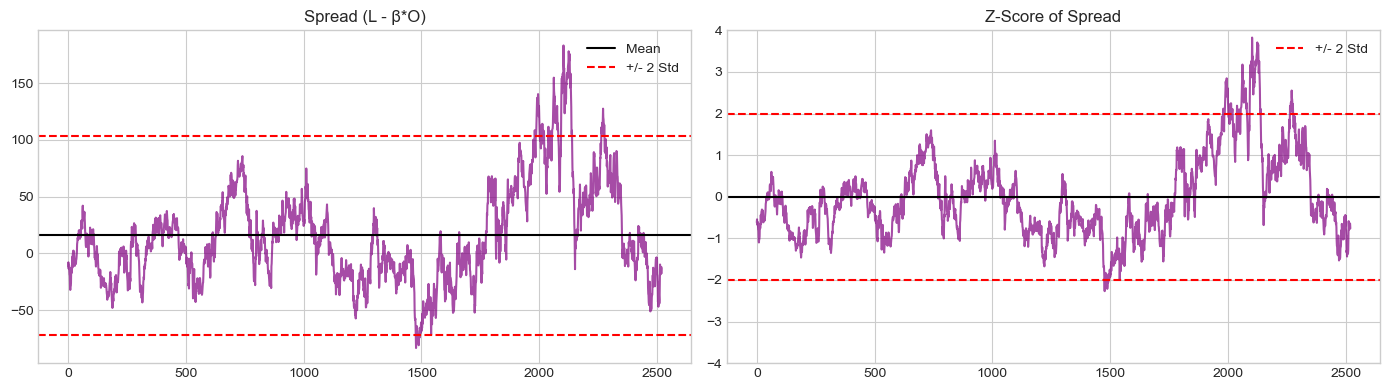

In [111]:
# Plot spread and z-score
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(spread, color='purple', alpha=0.7)
axes[0].axhline(spread_mean, color='black', linestyle='-', label='Mean')
axes[0].axhline(spread_mean + 2*spread_std, color='red', linestyle='--', label='+/- 2 Std')
axes[0].axhline(spread_mean - 2*spread_std, color='red', linestyle='--')
axes[0].set_title('Spread (L - β*O)')
axes[0].legend()

axes[1].plot(z_score, color='purple', alpha=0.7)
axes[1].axhline(0, color='black')
axes[1].axhline(2, color='red', linestyle='--', label='+/- 2 Std')
axes[1].axhline(-2, color='red', linestyle='--')
axes[1].set_title('Z-Score of Spread')
axes[1].set_ylim(-4, 4)
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Find Optimal Thresholds

In [112]:
def backtest_simple(z_score, stock_L, stock_O, hedge_ratio, entry_thresh, exit_thresh):
    """Quick backtest to evaluate threshold combinations."""
    position = 0
    trades = []
    
    for i in range(len(z_score)):
        z = z_score[i]
        if position == 0:
            if z > entry_thresh:
                position, entry_L, entry_O, entry_day = -1, stock_L[i], stock_O[i], i
            elif z < -entry_thresh:
                position, entry_L, entry_O, entry_day = 1, stock_L[i], stock_O[i], i
        elif position == 1 and z >= exit_thresh:
            pnl = (stock_L[i] - entry_L) - hedge_ratio * (stock_O[i] - entry_O)
            trades.append(pnl)
            position = 0
        elif position == -1 and z <= -exit_thresh:
            pnl = -(stock_L[i] - entry_L) + hedge_ratio * (stock_O[i] - entry_O)
            trades.append(pnl)
            position = 0
    
    return len(trades), sum(trades) if trades else 0, (sum(1 for t in trades if t > 0) / len(trades)) if trades else 0

# Grid search
results = []
for entry in np.arange(1.0, 2.6, 0.25):
    for exit_t in np.arange(0.0, 1.1, 0.25):
        if exit_t >= entry:
            continue
        n_trades, total_pnl, win_rate = backtest_simple(z_score, stock_L, stock_O, hedge_ratio, entry, exit_t)
        if n_trades >= 5:
            results.append({'entry': entry, 'exit': exit_t, 'trades': n_trades, 'pnl': total_pnl, 'win_rate': win_rate})

results_df = pd.DataFrame(results).sort_values('pnl', ascending=False)
print("Top 5 Threshold Combinations by PnL:")
print(results_df.head().to_string(index=False))

Top 5 Threshold Combinations by PnL:
 entry  exit  trades        pnl  win_rate
  1.00  0.00      15 785.291620       1.0
  1.00  0.25      12 769.469464       1.0
  1.00  0.50      10 749.659358       1.0
  1.25  0.00      11 699.952210       1.0
  1.25  0.25       8 614.378099       1.0


In [113]:
# Select optimal thresholds
ENTRY_THRESHOLD = results_df.iloc[0]['entry']
EXIT_THRESHOLD = results_df.iloc[0]['exit']
print(f"Selected: Entry = +/- {ENTRY_THRESHOLD:.2f} std, Exit = {EXIT_THRESHOLD:.2f} std")

Selected: Entry = +/- 1.00 std, Exit = 0.00 std


## 6. Trading Strategy Implementation

In [114]:
class PairsTradingStrategy:
    def __init__(self, hedge_ratio, spread_mean, spread_std, entry_threshold, exit_threshold, capital=100000):
        self.hedge_ratio = hedge_ratio
        self.spread_mean = spread_mean
        self.spread_std = spread_std
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        self.initial_capital = capital
        self.position = 0
        self.shares_L = 0
        self.shares_O = 0
        self.cash = capital
        self.trades = []
        self.position_history = []
        self.value_history = []
        
    def calc_z(self, price_L, price_O):
        return (price_L - self.hedge_ratio * price_O - self.spread_mean) / self.spread_std
    
    def calc_shares(self, price_L):
        shares_L = int(self.initial_capital * 0.4 / price_L)
        shares_O = int(shares_L * self.hedge_ratio)
        return shares_L, shares_O
    
    def open_long(self, day, price_L, price_O, z):
        shares_L, shares_O = self.calc_shares(price_L)
        self.position = 1
        self.shares_L, self.shares_O = shares_L, -shares_O
        self.entry_price_L, self.entry_price_O = price_L, price_O
        self.entry_day, self.entry_z = day, z
        self.cash += -shares_L * price_L + shares_O * price_O
        return f"Day {day}: OPEN LONG - Buy {shares_L} L @ ${price_L:.2f}, Short {shares_O} O @ ${price_O:.2f}"
    
    def open_short(self, day, price_L, price_O, z):
        shares_L, shares_O = self.calc_shares(price_L)
        self.position = -1
        self.shares_L, self.shares_O = -shares_L, shares_O
        self.entry_price_L, self.entry_price_O = price_L, price_O
        self.entry_day, self.entry_z = day, z
        self.cash += shares_L * price_L - shares_O * price_O
        return f"Day {day}: OPEN SHORT - Short {shares_L} L @ ${price_L:.2f}, Buy {shares_O} O @ ${price_O:.2f}"
    
    def close(self, day, price_L, price_O, z, reason='signal'):
        if self.position == 1:
            pnl_L = self.shares_L * (price_L - self.entry_price_L)
            pnl_O = (-self.shares_O) * (self.entry_price_O - price_O)
            self.cash += self.shares_L * price_L - (-self.shares_O) * price_O
        else:
            pnl_L = (-self.shares_L) * (self.entry_price_L - price_L)
            pnl_O = self.shares_O * (price_O - self.entry_price_O)
            self.cash += -(-self.shares_L) * price_L + self.shares_O * price_O
        
        total_pnl = pnl_L + pnl_O
        self.trades.append({
            'entry_day': self.entry_day, 'exit_day': day,
            'type': 'LONG' if self.position == 1 else 'SHORT',
            'entry_z': self.entry_z, 'exit_z': z,
            'shares_L': abs(self.shares_L), 'shares_O': abs(self.shares_O),
            'pnl': total_pnl, 'holding_days': day - self.entry_day
        })
        
        pos_type = 'LONG' if self.position == 1 else 'SHORT'
        self.position = 0
        self.shares_L = self.shares_O = 0
        suffix = ' (end of data)' if reason == 'end' else ''
        return f"Day {day}: CLOSE {pos_type}{suffix} - PnL: ${total_pnl:.2f}"
    
    def run(self, prices_L, prices_O):
        signals = []
        for i in range(len(prices_L)):
            z = self.calc_z(prices_L[i], prices_O[i])
            
            if self.position == 0:
                if z > self.entry_threshold:
                    signals.append(self.open_short(i, prices_L[i], prices_O[i], z))
                elif z < -self.entry_threshold:
                    signals.append(self.open_long(i, prices_L[i], prices_O[i], z))
            elif self.position == 1 and z >= self.exit_threshold:
                signals.append(self.close(i, prices_L[i], prices_O[i], z))
            elif self.position == -1 and z <= -self.exit_threshold:
                signals.append(self.close(i, prices_L[i], prices_O[i], z))
            
            self.position_history.append({'day': i, 'position': self.position, 'z': z})
            self.value_history.append(self.cash + self.shares_L * prices_L[i] + self.shares_O * prices_O[i])
        
        # Force close at end
        if self.position != 0:
            z = self.calc_z(prices_L[-1], prices_O[-1])
            signals.append(self.close(len(prices_L)-1, prices_L[-1], prices_O[-1], z, 'end'))
        
        return signals

In [115]:
# Run strategy
strategy = PairsTradingStrategy(hedge_ratio, spread_mean, spread_std, ENTRY_THRESHOLD, EXIT_THRESHOLD)
signals = strategy.run(stock_L, stock_O)

print("Trading Signals:")
for s in signals:
    print(f"  {s}")

Trading Signals:
  Day 8: OPEN LONG - Buy 232 L @ $171.85, Short 1658 O @ $28.17
  Day 43: CLOSE LONG - PnL: $10868.28
  Day 139: OPEN LONG - Buy 200 L @ $199.12, Short 1430 O @ $32.07
  Day 270: CLOSE LONG - PnL: $10707.30
  Day 305: OPEN LONG - Buy 193 L @ $206.72, Short 1379 O @ $33.65
  Day 359: CLOSE LONG - PnL: $10196.66
  Day 510: OPEN LONG - Buy 190 L @ $210.44, Short 1358 O @ $33.35
  Day 611: CLOSE LONG - PnL: $8555.86
  Day 689: OPEN SHORT - Short 151 L @ $263.86, Buy 1079 O @ $28.37
  Day 770: CLOSE SHORT - PnL: $7066.07
  Day 794: OPEN LONG - Buy 171 L @ $232.91, Short 1222 O @ $36.47
  Day 799: CLOSE LONG - PnL: $8287.03
  Day 856: OPEN LONG - Buy 151 L @ $263.21, Short 1079 O @ $40.81
  Day 870: CLOSE LONG - PnL: $6831.29
  Day 1011: OPEN SHORT - Short 133 L @ $299.55, Buy 950 O @ $31.43
  Day 1034: CLOSE SHORT - PnL: $7971.07
  Day 1137: OPEN LONG - Buy 191 L @ $209.09, Short 1365 O @ $34.28
  Day 1295: CLOSE LONG - PnL: $11028.99
  Day 1320: OPEN LONG - Buy 139 L @ $28

## 7. Results

In [116]:
trades_df = pd.DataFrame(strategy.trades)
total_pnl = trades_df['pnl'].sum()
win_rate = (trades_df['pnl'] > 0).mean()
final_value = strategy.value_history[-1]

# Calculate Sharpe Ratio from daily returns
value_series = np.array(strategy.value_history)
daily_returns = np.diff(value_series) / value_series[:-1]
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0

print(f"Performance Summary:")
print(f"  Total Trades: {len(trades_df)}")
print(f"  Win Rate: {win_rate:.1%}")
print(f"  Total PnL: ${total_pnl:,.2f}")
print(f"  Avg PnL/Trade: ${trades_df['pnl'].mean():,.2f}")
print(f"  Avg Holding: {trades_df['holding_days'].mean():.1f} days")
print(f"  Final Portfolio: ${final_value:,.2f}")
print(f"  Total Return: {(final_value - 100000) / 100000:.1%}")
print(f"  Sharpe Ratio: {sharpe_ratio:.2f}")

Performance Summary:
  Total Trades: 16
  Win Rate: 100.0%
  Total PnL: $121,793.52
  Avg PnL/Trade: $7,612.10
  Avg Holding: 96.4 days
  Final Portfolio: $221,793.52
  Total Return: 121.8%
  Sharpe Ratio: 1.10


In [117]:
print("\nTrade History:")
print(trades_df[['entry_day', 'exit_day', 'type', 'entry_z', 'exit_z', 'pnl', 'holding_days']].to_string(index=False))


Trade History:
 entry_day  exit_day  type   entry_z    exit_z      pnl  holding_days
         8        43  LONG -1.041873  0.030468 10868.28            35
       139       270  LONG -1.055972  0.169461 10707.30           131
       305       359  LONG -1.140602  0.069353 10196.66            54
       510       611  LONG -1.006355  0.024293  8555.86           101
       689       770 SHORT  1.031429 -0.040021  7066.07            81
       794       799  LONG -1.002665  0.106932  8287.03             5
       856       870  LONG -1.019422  0.016472  6831.29            14
      1011      1034 SHORT  1.347534 -0.024450  7971.07            23
      1137      1295  LONG -1.189463  0.131994 11028.99           158
      1320      1580  LONG -1.055836  0.065021  6800.31           260
      1597      1660  LONG -1.090626  0.065587  7121.31            63
      1710      1774  LONG -1.042075  0.082864  6042.87            64
      1783      1816 SHORT  1.123088 -0.273696  6820.80            33
    

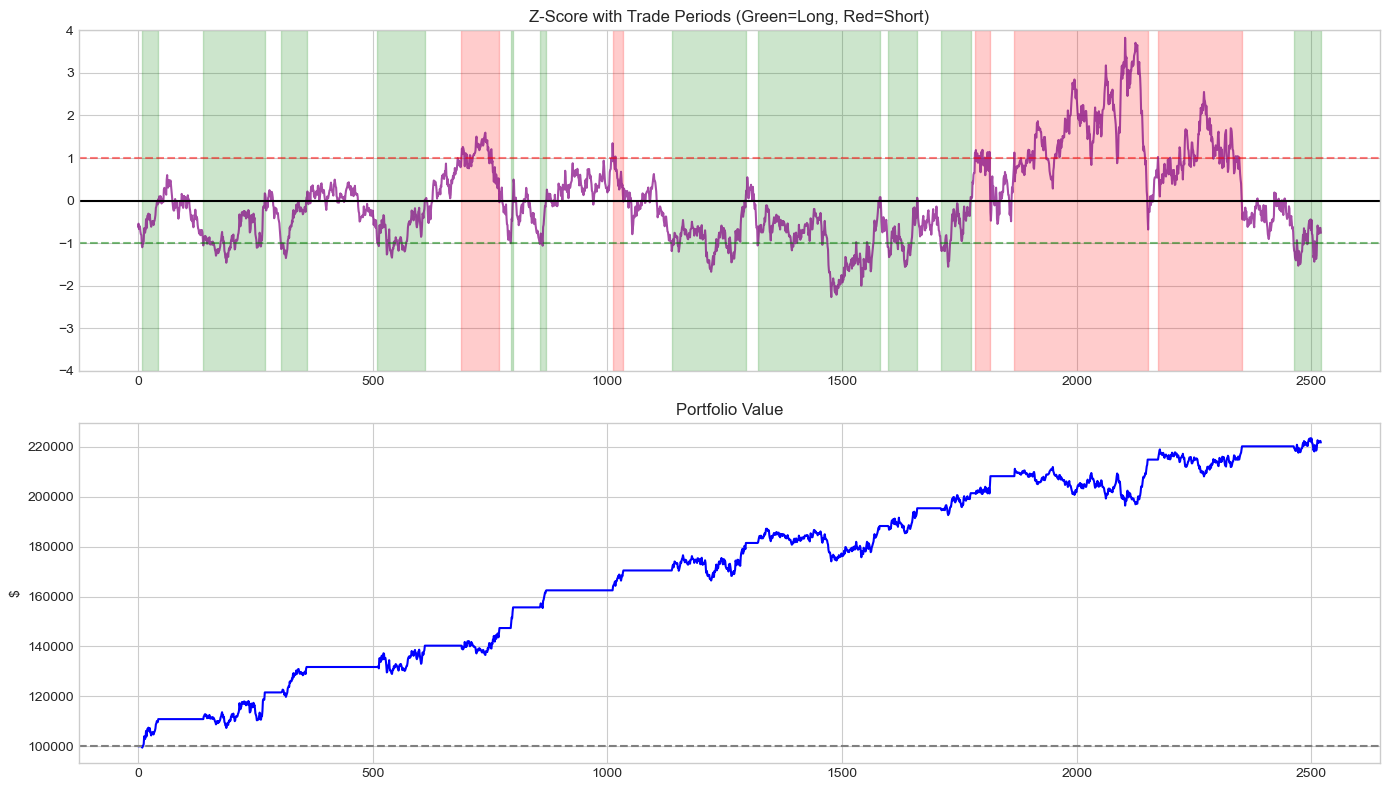

In [118]:
# Plot results
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Z-score with trades
pos_df = pd.DataFrame(strategy.position_history)
axes[0].plot(pos_df['z'], color='purple', alpha=0.7)
axes[0].axhline(0, color='black')
axes[0].axhline(ENTRY_THRESHOLD, color='red', linestyle='--', alpha=0.5)
axes[0].axhline(-ENTRY_THRESHOLD, color='green', linestyle='--', alpha=0.5)
for t in strategy.trades:
    color = 'green' if t['type'] == 'LONG' else 'red'
    axes[0].axvspan(t['entry_day'], t['exit_day'], alpha=0.2, color=color)
axes[0].set_title('Z-Score with Trade Periods (Green=Long, Red=Short)')
axes[0].set_ylim(-4, 4)

# Portfolio value
axes[1].plot(strategy.value_history, color='blue')
axes[1].axhline(100000, color='gray', linestyle='--')
axes[1].set_title('Portfolio Value')
axes[1].set_ylabel('$')

plt.tight_layout()
plt.show()

## 8. Summary

In [119]:
print("PAIRS TRADING STRATEGY SUMMARY")
print("=" * 50)
print(f"\nCointegration: P-value = {pvalue:.4f} (Confirmed)")
print(f"Hedge Ratio: {hedge_ratio:.4f}")
print(f"Entry: |Z| > {ENTRY_THRESHOLD:.2f}, Exit: |Z| < {EXIT_THRESHOLD:.2f}")
print(f"\nTrading Rules:")
print(f"  LONG spread (buy L, short O): when Z < -{ENTRY_THRESHOLD:.2f}")
print(f"  SHORT spread (short L, buy O): when Z > +{ENTRY_THRESHOLD:.2f}")
print(f"  Close: when Z reverts to {EXIT_THRESHOLD:.2f}")
print(f"\nResults: {len(trades_df)} trades, {win_rate:.0%} win rate, {(final_value-100000)/100000:.1%} return")
print(f"\nNote: Uses full dataset for parameters (look-ahead bias). No transaction costs.")

PAIRS TRADING STRATEGY SUMMARY

Cointegration: P-value = 0.0191 (Confirmed)
Hedge Ratio: 7.1503
Entry: |Z| > 1.00, Exit: |Z| < 0.00

Trading Rules:
  LONG spread (buy L, short O): when Z < -1.00
  SHORT spread (short L, buy O): when Z > +1.00
  Close: when Z reverts to 0.00

Results: 16 trades, 100% win rate, 121.8% return

Note: Uses full dataset for parameters (look-ahead bias). No transaction costs.


In [120]:
# Export
trades_df.to_csv('trade_history_LO.csv', index=False)
print("Trade history saved to trade_history_LO.csv")

Trade history saved to trade_history_LO.csv


## 9. Rolling Window Backtest (Window = 1000 days)

This backtest eliminates look-ahead bias by calculating hedge ratio, spread mean, and spread std using only the previous 1000 days of data at each point in time.

In [121]:
def rolling_window_backtest(stock_L, stock_O, window=1000, entry_thresh=1.0, exit_thresh=0.0,
                            max_holding_days=200, capital=100000):
    """
    Pairs trading backtest with rolling window for z-score calculation.
    
    Parameters:
    - window: lookback period for calculating hedge ratio, mean, and std
    - entry_thresh: z-score threshold to enter a trade
    - exit_thresh: z-score threshold to exit a trade
    - max_holding_days: force close position after this many days (trading rule)
    """
    n = len(stock_L)
    
    # Arrays to store rolling parameters and z-scores
    rolling_hedge = np.full(n, np.nan)
    rolling_mean = np.full(n, np.nan)
    rolling_std = np.full(n, np.nan)
    rolling_z = np.full(n, np.nan)
    
    # Calculate rolling parameters starting from day `window`
    for i in range(window, n):
        # Get window data
        L_window = stock_L[i-window:i]
        O_window = stock_O[i-window:i]
        
        # Calculate hedge ratio via OLS
        model = OLS(L_window, add_constant(O_window)).fit()
        beta = model.params[1]
        
        # Calculate spread statistics over window
        spread_window = L_window - beta * O_window
        mean_spread = spread_window.mean()
        std_spread = spread_window.std()
        
        # Store parameters
        rolling_hedge[i] = beta
        rolling_mean[i] = mean_spread
        rolling_std[i] = std_spread
        
        # Calculate current z-score using rolling parameters
        current_spread = stock_L[i] - beta * stock_O[i]
        rolling_z[i] = (current_spread - mean_spread) / std_spread
    
    # Trading simulation
    position = 0  # 0: flat, 1: long spread, -1: short spread
    trades = []
    position_history = []
    cash = capital
    shares_L = 0
    shares_O = 0
    value_history = []
    
    for i in range(window, n):
        z = rolling_z[i]
        hedge = rolling_hedge[i]
        price_L = stock_L[i]
        price_O = stock_O[i]
        
        # Position sizing (40% of initial capital)
        target_shares_L = int(capital * 0.4 / price_L)
        target_shares_O = int(target_shares_L * hedge)
        
        # Check for max holding period exit
        if position != 0 and (i - entry_day) >= max_holding_days:
            if position == 1:
                pnl = shares_L * (price_L - entry_price_L) + (-shares_O) * (entry_price_O - price_O)
                cash += shares_L * price_L - (-shares_O) * price_O
            else:
                pnl = (-shares_L) * (entry_price_L - price_L) + shares_O * (price_O - entry_price_O)
                cash += -(-shares_L) * price_L + shares_O * price_O
            trades.append({
                'entry_day': entry_day, 'exit_day': i, 'type': 'LONG' if position == 1 else 'SHORT',
                'entry_z': entry_z, 'exit_z': z, 'pnl': pnl,
                'holding_days': i - entry_day, 'exit_reason': 'max_holding'
            })
            position, shares_L, shares_O = 0, 0, 0
        
        if position == 0:
            # Entry signals
            if z > entry_thresh:  # Spread too high -> short spread
                position = -1
                shares_L = -target_shares_L
                shares_O = target_shares_O
                entry_price_L, entry_price_O = price_L, price_O
                entry_day, entry_z = i, z
                cash += target_shares_L * price_L - target_shares_O * price_O
                
            elif z < -entry_thresh:  # Spread too low -> long spread
                position = 1
                shares_L = target_shares_L
                shares_O = -target_shares_O
                entry_price_L, entry_price_O = price_L, price_O
                entry_day, entry_z = i, z
                cash += -target_shares_L * price_L + target_shares_O * price_O
                
        elif position == 1 and z >= exit_thresh:  # Exit long
            pnl = shares_L * (price_L - entry_price_L) + (-shares_O) * (entry_price_O - price_O)
            cash += shares_L * price_L - (-shares_O) * price_O
            trades.append({
                'entry_day': entry_day, 'exit_day': i, 'type': 'LONG',
                'entry_z': entry_z, 'exit_z': z, 'pnl': pnl,
                'holding_days': i - entry_day, 'exit_reason': 'signal'
            })
            position, shares_L, shares_O = 0, 0, 0
            
        elif position == -1 and z <= -exit_thresh:  # Exit short
            pnl = (-shares_L) * (entry_price_L - price_L) + shares_O * (price_O - entry_price_O)
            cash += -(-shares_L) * price_L + shares_O * price_O
            trades.append({
                'entry_day': entry_day, 'exit_day': i, 'type': 'SHORT',
                'entry_z': entry_z, 'exit_z': z, 'pnl': pnl,
                'holding_days': i - entry_day, 'exit_reason': 'signal'
            })
            position, shares_L, shares_O = 0, 0, 0
        
        # Track position and portfolio value
        position_history.append({'day': i, 'position': position, 'z': z})
        portfolio_value = cash + shares_L * price_L + shares_O * price_O
        value_history.append(portfolio_value)
    
    # Force close any open position at end
    if position != 0:
        i = n - 1
        price_L, price_O = stock_L[i], stock_O[i]
        if position == 1:
            pnl = shares_L * (price_L - entry_price_L) + (-shares_O) * (entry_price_O - price_O)
        else:
            pnl = (-shares_L) * (entry_price_L - price_L) + shares_O * (price_O - entry_price_O)
        trades.append({
            'entry_day': entry_day, 'exit_day': i, 'type': 'LONG' if position == 1 else 'SHORT',
            'entry_z': entry_z, 'exit_z': rolling_z[i], 'pnl': pnl,
            'holding_days': i - entry_day, 'exit_reason': 'end_of_data'
        })
        cash += shares_L * price_L + shares_O * price_O
        value_history[-1] = cash
    
    return {
        'trades': pd.DataFrame(trades),
        'position_history': pd.DataFrame(position_history),
        'value_history': value_history,
        'rolling_z': rolling_z,
        'rolling_hedge': rolling_hedge,
        'final_value': value_history[-1] if value_history else capital
    }

# Run rolling window backtest with max holding period
WINDOW = 1000
MAX_HOLDING = 150  # Exit after 150 days max

results_rolling = rolling_window_backtest(stock_L, stock_O, window=WINDOW, 
                                          entry_thresh=ENTRY_THRESHOLD, 
                                          exit_thresh=EXIT_THRESHOLD,
                                          max_holding_days=MAX_HOLDING)

print(f"Rolling Window Backtest (Window = {WINDOW} days, Max Holding = {MAX_HOLDING} days)")
print("=" * 65)
print(f"Trading period: Day {WINDOW} to Day {len(stock_L)-1}")
print(f"Out-of-sample days: {len(stock_L) - WINDOW}")

Rolling Window Backtest (Window = 1000 days, Max Holding = 150 days)
Trading period: Day 1000 to Day 2520
Out-of-sample days: 1521


In [122]:
# Display rolling backtest results
trades_rolling = results_rolling['trades']
final_val_rolling = results_rolling['final_value']

if len(trades_rolling) > 0:
    total_pnl_rolling = trades_rolling['pnl'].sum()
    win_rate_rolling = (trades_rolling['pnl'] > 0).mean()
    avg_pnl_rolling = trades_rolling['pnl'].mean()
    avg_holding_rolling = trades_rolling['holding_days'].mean()
    
    # Calculate Sharpe Ratio from daily returns
    value_series_rolling = np.array(results_rolling['value_history'])
    daily_returns_rolling = np.diff(value_series_rolling) / value_series_rolling[:-1]
    sharpe_ratio_rolling = (daily_returns_rolling.mean() / daily_returns_rolling.std()) * np.sqrt(252) if daily_returns_rolling.std() > 0 else 0
    
    print(f"\nPerformance Summary (Rolling Window, Max Holding = {MAX_HOLDING} days):")
    print(f"  Total Trades: {len(trades_rolling)}")
    print(f"  Win Rate: {win_rate_rolling:.1%}")
    print(f"  Total PnL: ${total_pnl_rolling:,.2f}")
    print(f"  Avg PnL/Trade: ${avg_pnl_rolling:,.2f}")
    print(f"  Avg Holding: {avg_holding_rolling:.1f} days")
    print(f"  Final Portfolio: ${final_val_rolling:,.2f}")
    print(f"  Total Return: {(final_val_rolling - 100000) / 100000:.1%}")
    print(f"  Sharpe Ratio: {sharpe_ratio_rolling:.2f}")
    
    # Count exits by reason
    exit_counts = trades_rolling['exit_reason'].value_counts()
    print(f"\nExit Reasons:")
    for reason, count in exit_counts.items():
        print(f"  {reason}: {count}")
    
    print(f"\nTrade History (Rolling Window):")
    print(trades_rolling[['entry_day', 'exit_day', 'type', 'entry_z', 'exit_z', 'pnl', 'holding_days', 'exit_reason']].to_string(index=False))
else:
    print("No trades executed during the rolling window period.")


Performance Summary (Rolling Window, Max Holding = 150 days):
  Total Trades: 12
  Win Rate: 75.0%
  Total PnL: $32,108.18
  Avg PnL/Trade: $2,675.68
  Avg Holding: 92.6 days
  Final Portfolio: $132,108.18
  Total Return: 32.1%
  Sharpe Ratio: 0.49

Exit Reasons:
  signal: 7
  max_holding: 4
  end_of_data: 1

Trade History (Rolling Window):
 entry_day  exit_day  type   entry_z    exit_z      pnl  holding_days exit_reason
      1005      1045 SHORT  1.339712 -0.041059  5070.24            40      signal
      1053      1064  LONG -1.011384  0.024138  4924.91            11      signal
      1130      1280  LONG -1.043482 -0.476278  1305.90           150 max_holding
      1292      1320 SHORT  1.026274 -0.217098  3746.40            28      signal
      1471      1569  LONG -1.295534  0.010893  4564.92            98      signal
      1581      1601 SHORT  1.247988 -0.015143  4054.31            20      signal
      1621      1771 SHORT  1.132232  1.435227 -5224.79           150 max_holding


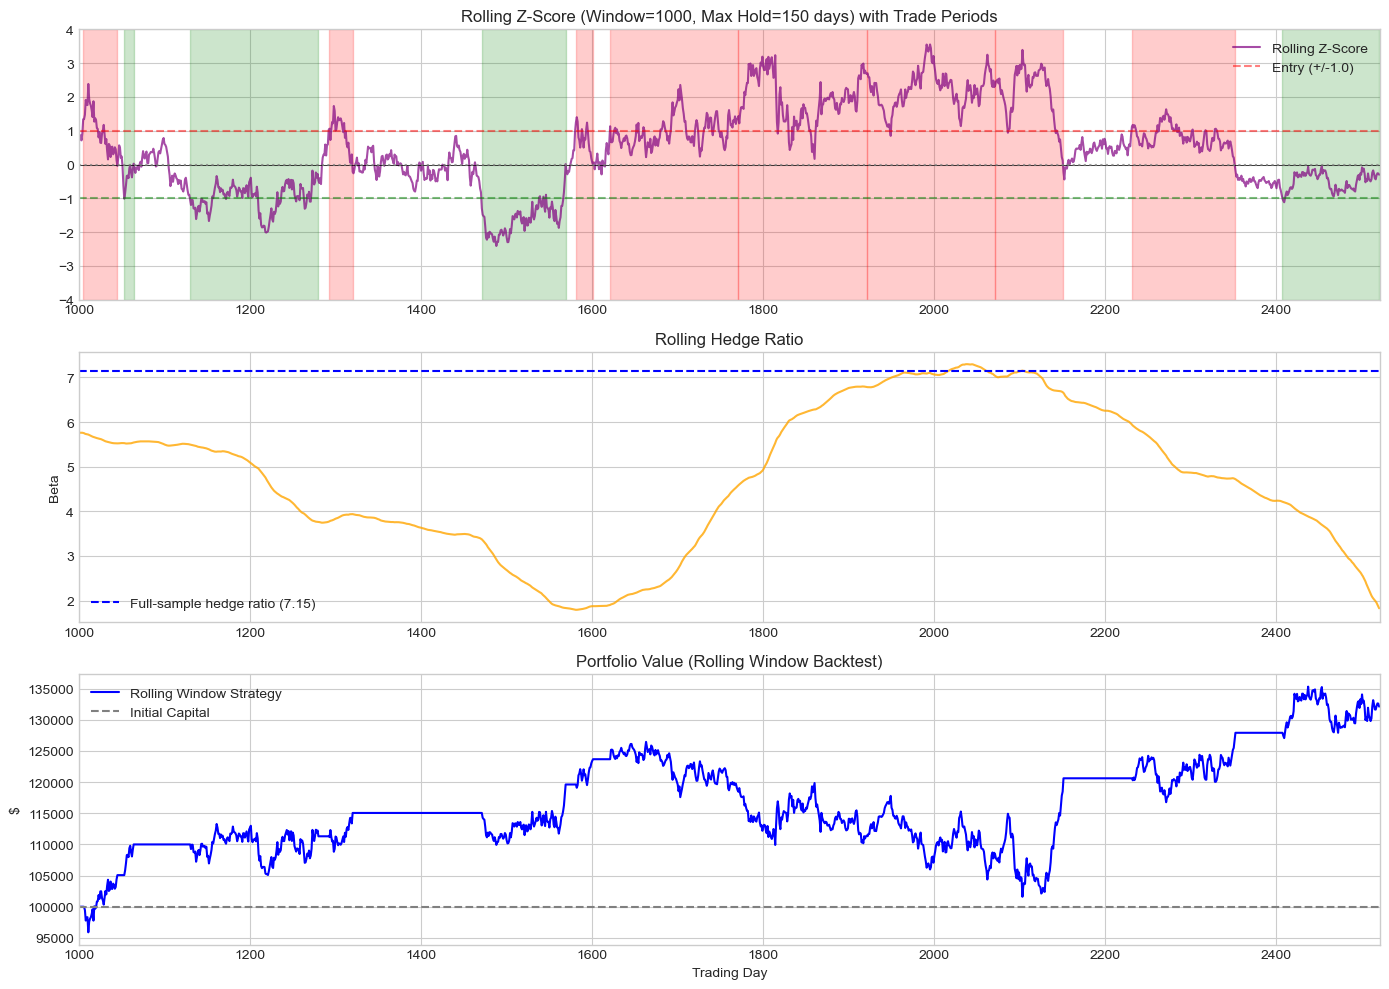

In [123]:
# Plot rolling window backtest results
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Rolling Z-score with trade periods
rolling_z = results_rolling['rolling_z']
axes[0].plot(range(WINDOW, len(rolling_z)), rolling_z[WINDOW:], color='purple', alpha=0.7, label='Rolling Z-Score')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axhline(ENTRY_THRESHOLD, color='red', linestyle='--', alpha=0.5, label=f'Entry (+/-{ENTRY_THRESHOLD})')
axes[0].axhline(-ENTRY_THRESHOLD, color='green', linestyle='--', alpha=0.5)
axes[0].axhline(EXIT_THRESHOLD, color='gray', linestyle=':', alpha=0.5)
axes[0].axhline(-EXIT_THRESHOLD, color='gray', linestyle=':', alpha=0.5)
for _, t in trades_rolling.iterrows():
    color = 'green' if t['type'] == 'LONG' else 'red'
    axes[0].axvspan(t['entry_day'], t['exit_day'], alpha=0.2, color=color)
axes[0].set_title(f'Rolling Z-Score (Window={WINDOW}, Max Hold={MAX_HOLDING} days) with Trade Periods')
axes[0].set_ylim(-4, 4)
axes[0].legend(loc='upper right')
axes[0].set_xlim(WINDOW, len(stock_L))

# Rolling hedge ratio
rolling_hedge = results_rolling['rolling_hedge']
axes[1].plot(range(WINDOW, len(rolling_hedge)), rolling_hedge[WINDOW:], color='orange', alpha=0.8)
axes[1].axhline(hedge_ratio, color='blue', linestyle='--', label=f'Full-sample hedge ratio ({hedge_ratio:.2f})')
axes[1].set_title('Rolling Hedge Ratio')
axes[1].set_ylabel('Beta')
axes[1].legend()
axes[1].set_xlim(WINDOW, len(stock_L))

# Portfolio value
days_rolling = list(range(WINDOW, len(stock_L)))
axes[2].plot(days_rolling, results_rolling['value_history'], color='blue', label='Rolling Window Strategy')
axes[2].axhline(100000, color='gray', linestyle='--', label='Initial Capital')
axes[2].set_title('Portfolio Value (Rolling Window Backtest)')
axes[2].set_ylabel('$')
axes[2].set_xlabel('Trading Day')
axes[2].legend()
axes[2].set_xlim(WINDOW, len(stock_L))

plt.tight_layout()
plt.show()

In [124]:
# Compare rolling vs full-sample strategies
print("COMPARISON: Rolling Window vs Full-Sample Strategy")
print("=" * 65)
print(f"\n{'Metric':<25} {'Full-Sample':>15} {'Rolling Window':>15}")
print("-" * 65)
print(f"{'Trades':<25} {len(trades_df):>15} {len(trades_rolling):>15}")
print(f"{'Win Rate':<25} {win_rate:>14.1%} {win_rate_rolling:>14.1%}")
print(f"{'Total PnL':<25} ${total_pnl:>13,.2f} ${total_pnl_rolling:>13,.2f}")
print(f"{'Avg PnL/Trade':<25} ${trades_df['pnl'].mean():>13,.2f} ${avg_pnl_rolling:>13,.2f}")
print(f"{'Final Portfolio':<25} ${final_value:>13,.2f} ${final_val_rolling:>13,.2f}")
print(f"{'Total Return':<25} {(final_value-100000)/100000:>14.1%} {(final_val_rolling-100000)/100000:>14.1%}")
print(f"{'Sharpe Ratio':<25} {sharpe_ratio:>15.2f} {sharpe_ratio_rolling:>15.2f}")
print("-" * 65)
print(f"\nRolling Window Strategy Rules:")
print(f"  - Window: {WINDOW} days for parameter estimation")
print(f"  - Entry: |Z| > {ENTRY_THRESHOLD}")
print(f"  - Exit: |Z| < {EXIT_THRESHOLD} OR held > {MAX_HOLDING} days")

COMPARISON: Rolling Window vs Full-Sample Strategy

Metric                        Full-Sample  Rolling Window
-----------------------------------------------------------------
Trades                                 16              12
Win Rate                          100.0%          75.0%
Total PnL                 $   121,793.52 $    32,108.18
Avg PnL/Trade             $     7,612.10 $     2,675.68
Final Portfolio           $   221,793.52 $   132,108.18
Total Return                      121.8%          32.1%
Sharpe Ratio                         1.10            0.49
-----------------------------------------------------------------

Rolling Window Strategy Rules:
  - Window: 1000 days for parameter estimation
  - Entry: |Z| > 1.0
  - Exit: |Z| < 0.0 OR held > 150 days
